In [3]:
import glob
import h5py
import numpy as np
from fastai.basics import *
from fastai.callback.schedule import fit_one_cycle
from fastai.callback.hook import summary
from fastai.callback.tracker import SaveModelCallback
from fastai.callback.fp16 import *
from fastai.data.load import DataLoader as FastDataLoader
from fastai.callback.progress import CSVLogger
from torch.utils.data import *
from collections.abc import Iterable
from data_utils import *

## Create Datasets

In [4]:
root = '/home/featurize/data/Generate_Data_Step_0_496_264_20020601_20190409.mat'
train_dataset = MyDataset(root, mode='train', in_channels=32, out_channels=32, steps=1)
valid_dataset = MyDataset(root, mode='valid', in_channels=32, out_channels=32, steps=1)
test_dataset = MyDataset(root, mode='test', in_channels=32, out_channels=32, steps=1)

In [5]:
batch_size = 6
device = 'cuda'
folder_to_save_models = 'weights'

train_dl = FastDataLoader(dataset=train_dataset,
                          bs=batch_size,
                          pin_memory=True,
                          shuffle=True,
                          device=torch.device(device))
valid_dl = FastDataLoader(dataset=valid_dataset,
                          bs=batch_size,
                          pin_memory=True,
                          shuffle=True,
                          device=torch.device(device))
test_dl = FastDataLoader(dataset=test_dataset,
                          bs=batch_size,
                          pin_memory=True,
                          shuffle=False,
                          device=torch.device(device))
data = DataLoaders(train_dl, valid_dl, device=torch.device(device))
test_data = DataLoaders(test_dl, device=torch.device(device))

In [6]:
from vunet_conv1d import Net1, VUNetLoss2, valid_leaderboard, valid_leaderboard2
Model = Net1(in_channels=32,out_channels=32)

In [7]:
learn = Learner(data, Model.to(device), loss_func=VUNetLoss2, metrics=[valid_leaderboard, valid_leaderboard2], model_dir=folder_to_save_models, cbs=CSVLogger)

In [8]:
learn.summary()

Net1 (Input shape: 6 x 32 x 256 x 256)
Layer (type)         Output Shape         Param #    Trainable 
                     6 x 64 x 256 x 256  
Conv2d                                    18496      True      
ELU                                                            
GroupNorm                                 128        True      
Dropout2d                                                      
Conv2d                                    55360      True      
ELU                                                            
GroupNorm                                 128        True      
Dropout2d                                                      
Conv2d                                    92224      True      
ELU                                                            
GroupNorm                                 128        True      
Dropout2d                                                      
Conv2d                                    129088     True      
ELU                    

In [7]:
# torch.cuda.empty_cache()
# torch.cuda.memory_summary()

## Training

In [8]:
learn.fit_one_cycle(2, lr_max=2e-04)

epoch,train_loss,valid_loss,valid_leaderboard,valid_leaderboard2,time
0,73.369225,3.687702,0.004506,0.004506,41:07
1,24.238598,0.110860,0.002949,0.002949,41:05


In [9]:
learn.save('Comb_2')

Path('weights/Comb_2.pth')

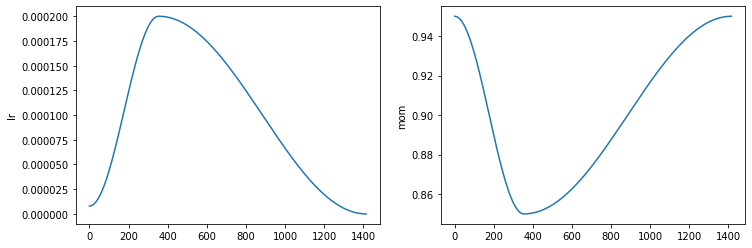

In [10]:
learn.recorder.plot_sched()

In [12]:
learn.fit_flat_cos(2, lr=2e-04, pct_start=0)

epoch,train_loss,valid_loss,valid_leaderboard,valid_leaderboard2,time
0,0.251354,0.095048,0.001316,0.001316,32:35
1,0.076558,0.002068,0.001418,0.001418,33:20


In [13]:
learn.save('Comb_4')

Path('weights/Comb_4.pth')

In [14]:
learn.fit_flat_cos(2, lr=2e-04, pct_start=0)

epoch,train_loss,valid_loss,valid_leaderboard,valid_leaderboard2,time
0,0.102324,0.061777,0.001814,0.001814,33:50
1,0.034046,0.001675,0.001352,0.001352,33:02


In [15]:
learn.save('Comb_6')

Path('weights/Comb_6.pth')

In [11]:
learn.fit_flat_cos(2, lr=2e-04, pct_start=0)

epoch,train_loss,valid_loss,valid_leaderboard,valid_leaderboard2,time
0,1.193228,0.279274,0.001607,0.001607,42:45
1,0.255288,0.005079,0.002045,0.002045,42:16


In [12]:
learn.save('Comb_8')

Path('weights/Comb_8.pth')

## Testing

In [9]:
learn.load('Comb_8')

In [10]:
x, y = test_dl.one_batch()
preds = learn.model(x)

In [24]:
# print(x.shape, y.shape)
# preds, targets = learn.get_preds(2)
sample = preds[0][0].cpu().detach().numpy()
print(sample.shape)

(32, 256, 256)


In [25]:
label = y[2].cpu().detach().numpy()
input = x[2].cpu().detach().numpy()
print(input.shape)

(32, 256, 256)


In [26]:
sample = recover(sample, 17, 32)
label = recover(label, 17, 32)
input = recover(input, 17, 32)

In [27]:
print(sample[:,0,0])
print(label[:,0,0])
print(input[:,0,0])

[20.943958 21.725325 21.660177 21.256968 21.650414 22.345037 21.910597
 21.731655 22.772846 22.78005  22.109173 22.531033 21.623558 22.04997
 22.550966 21.85723  21.972656 21.135765 21.602955 22.356415 21.405983
 22.335398 21.967407 21.987604 22.423784 21.277912 22.503777 21.831078
 21.62698  21.7482   21.363842 22.295263]
[22.69   22.6375 22.7575 22.7    22.9175 22.6075 22.8475 22.66   22.87
 22.645  22.76   22.915  22.535  22.645  22.49   22.95   22.6525 22.7275
 22.625  22.5325 22.6    22.6525 22.62   22.4825 22.6025 22.7225 22.995
 22.8675 23.02   23.0725 23.0925 23.205 ]
[22.9375 23.0925 23.1625 23.235  22.8525 22.9375 22.915  22.9725 23.125
 22.9675 22.875  23.01   22.9325 22.7475 22.8925 22.8575 22.6825 22.6725
 22.7625 22.6975 22.685  22.65   22.6625 22.5625 22.63   22.5975 22.69
 22.73   22.5525 22.6    22.51   22.6175]


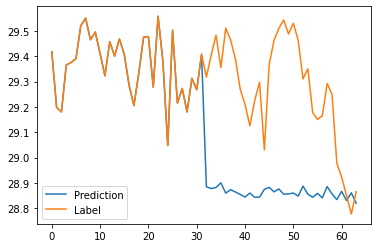

In [28]:
idx = [100, 100]
plt.plot(concat(input[:,idx[0], idx[1]], sample[:,idx[0], idx[1]]))
plt.plot(concat(input[:,idx[0], idx[1]], label[:,idx[0], idx[1]]))
plt.legend(['Prediction', 'Label'])

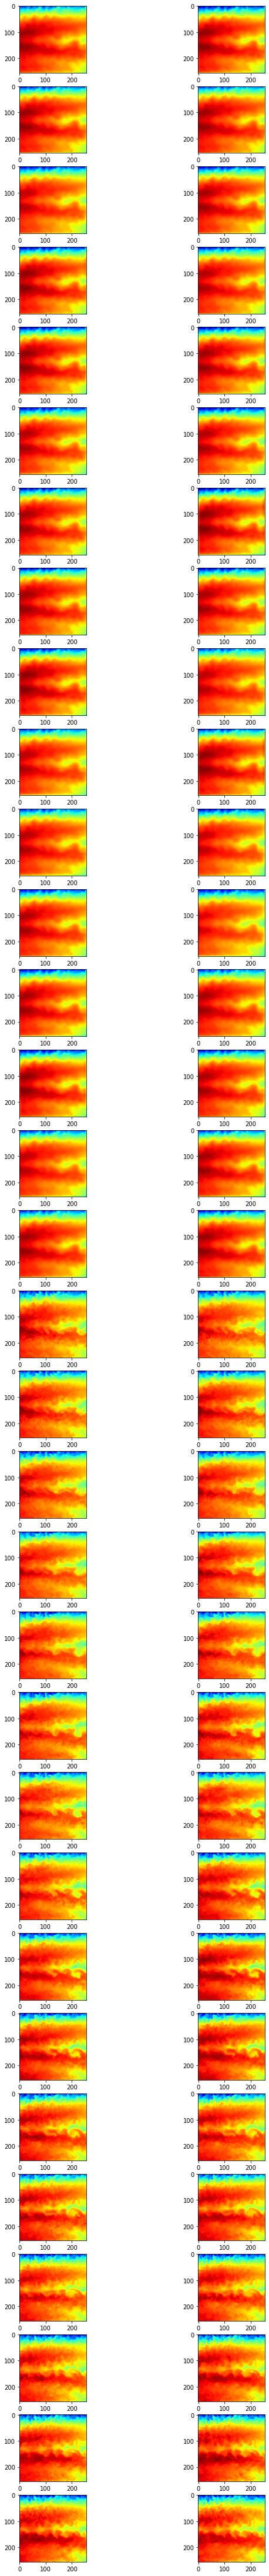

In [29]:
plt.figure(figsize=(10,80))
for i in range(sample.shape[0]):
    plt.subplot(sample.shape[0], 2, i+1)
    plt.imshow(sample[i], cmap='jet')
    plt.subplot(sample.shape[0], 2, i+1+sample.shape[0])
    plt.imshow(label[i], cmap='jet')
